In [8]:
import torch
from torch import nn, Tensor
from torchvision import models, transforms

from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import plotly.express as px

In [9]:
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

# models

In [13]:
class Vit(nn.Module):
    def __init__(self, variant="vit_b_16") -> None:
        super().__init__()
        if variant == "vit_b_16":
            self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        elif variant == "vit_b_32":
            self.model = models.vit_b_32(weights=models.ViT_B_32_Weights.DEFAULT)
        elif variant == "vit_l_16":
            self.model = models.vit_l_16(weights=models.ViT_L_16_Weights.DEFAULT)
        elif variant == "vit_l_32":
            self.model = models.vit_l_32(weights=models.ViT_L_32_Weights.DEFAULT)
        elif variant == "vit_h_14":
            self.model = models.vit_h_14(weights=models.ViT_H_14_Weights.DEFAULT)

    def forward(self, x: Tensor) -> Tensor:
        # Reshape and permute the input tensor
        x = self.model._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.model.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        return x

In [14]:
model = Vit().to(device)
model.eval()

Vit(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((

In [15]:
model(torch.zeros(1, 3, 224, 224).to(device)).shape

torch.Size([1, 768])

In [16]:
transform = models.ResNet50_Weights.DEFAULT.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [18]:
transform(torch.zeros(1, 3, 512, 512)).shape

torch.Size([1, 3, 224, 224])

# images

In [19]:
image_dict = {}
for i in glob("*.jpg"):
    image_dict[i.split(".")[0]] = Image.open(i)
list(image_dict.keys())

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [20]:
image_dict[list(image_dict.keys())[0]].size

(1280, 1280)

In [21]:
def preprocess(image_dict: dict) -> dict:
    procss_images = {}
    for k, v in image_dict.items():
        procss_images[k] = transform(v)
    return procss_images

In [22]:
procss_images = preprocess(image_dict)
procss_images[list(procss_images.keys())[0]].shape

torch.Size([3, 224, 224])

# run

In [23]:
with torch.inference_mode():
    extracts = model(torch.stack(list(procss_images.values()), dim=0).to(device))
extracts.shape

torch.Size([10, 768])

In [24]:
temp = extracts[:1]
temp.shape

torch.Size([1, 768])

In [25]:
# l2norm
temp.norm(p=2, dim=-1), temp.square().sum().sqrt()

(tensor([14.2712], device='cuda:0'), tensor(14.2712, device='cuda:0'))

In [26]:
# l1norm
temp.norm(p=1, dim=-1), temp.abs().sum()

(tensor([310.6520], device='cuda:0'), tensor(310.6520, device='cuda:0'))

# cosine similarity


[cosine similarity 详细介绍](../01_PyTorch基本/05数学运算/cosine%20similarity.ipynb)

In [27]:
cos_similarity_t = (extracts / extracts.norm(p=2, dim=1, keepdim=True)) @ (extracts / extracts.norm(p=2, dim=1, keepdim=True)).T
cos_similarity_t

tensor([[ 1.0000,  0.4382,  0.4302,  0.3713,  0.6627,  0.0671,  0.0975,  0.0428,
          0.1299,  0.0644],
        [ 0.4382,  1.0000,  0.3674,  0.5657,  0.5057,  0.0791,  0.0671,  0.0647,
          0.0778,  0.0598],
        [ 0.4302,  0.3674,  1.0000,  0.5639,  0.5014,  0.0822,  0.1137,  0.0219,
          0.0819,  0.0957],
        [ 0.3713,  0.5657,  0.5639,  1.0000,  0.4444,  0.1331,  0.0809,  0.0311,
          0.1509,  0.1006],
        [ 0.6627,  0.5057,  0.5014,  0.4444,  1.0000,  0.1238,  0.0861,  0.0711,
          0.1356,  0.0798],
        [ 0.0671,  0.0791,  0.0822,  0.1331,  0.1238,  1.0000,  0.1618,  0.1566,
          0.0099,  0.2686],
        [ 0.0975,  0.0671,  0.1137,  0.0809,  0.0861,  0.1618,  1.0000, -0.0365,
          0.0481,  0.1638],
        [ 0.0428,  0.0647,  0.0219,  0.0311,  0.0711,  0.1566, -0.0365,  1.0000,
          0.1324,  0.2322],
        [ 0.1299,  0.0778,  0.0819,  0.1509,  0.1356,  0.0099,  0.0481,  0.1324,
          1.0000,  0.1598],
        [ 0.0644,  

In [28]:
cos_similarity = cos_similarity_t.cpu().detach().numpy()

In [29]:
names = list(procss_images.keys())
names

['cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5']

In [30]:
figure = px.imshow(cos_similarity, text_auto=True, x=names, y=names, width=800, height=800, title="cat, dog cos similarity")
figure.show()

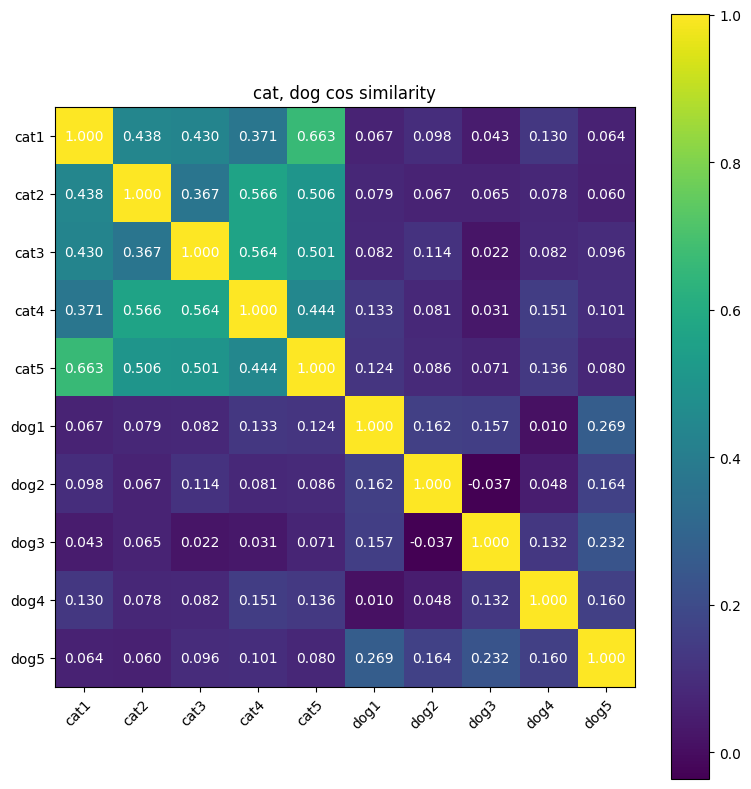

In [31]:
plt.figure(figsize=(8, 8))
plt.xticks(np.arange(len(names)), labels=names, rotation=45, rotation_mode="anchor", ha="right")
plt.yticks(np.arange(len(names)), labels=names)
plt.title("cat, dog cos similarity")

# 绘图
plt.imshow(cos_similarity)

# 添加文字
for i in range(len(names)):
    for j in range(len(names)):
        text = plt.text(j, i, "{:.3f}".format(cos_similarity[i, j]), ha="center", va="center", color="w")

plt.colorbar()      # 右侧的条
plt.tight_layout()
plt.show()